In [1]:
import os
import xarray as xr
import dask.array as da
from tqdm import tqdm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
from xarray.conventions import decode_cf
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [2]:
o = xr.open_dataset("1984-01-01.nc")
lon, lat = o.longitude, o.latitude
o.close()
def findlon(n):
    return list(lon.values).index(lon.sel(longitude=n,method='nearest'))
def findlat(t):
    return list(lat.values).index(lat.sel(latitude=t,method='nearest'))
def nearestlon(n):
    return lon.sel(longitude=n,method='nearest').data.item()
def nearestlat(t):
    return lat.sel(latitude=t,method='nearest').data.item()
# CHECK IF THIS IS NEEDED HERE OR NOT
# CHECK IF THIS IS NEEDED HERE OR NOT
# CHECK IF THIS IS NEEDED HERE OR NOT
def fll(year,n,t):
    return annual_sums[year][list(lat.values).index(lat.sel(latitude=t,method='nearest'))][list(lon.values).index(lon.sel(longitude=n,method='nearest'))]

In [5]:
try:
    os.chdir('./data')
    print("in data")
except:
    print("probably already in data")

in data


In [16]:
annual_sums = np.zeros((34,241,480))
for year in tqdm(np.arange(1984, 2018)):
    f = xr.open_mfdataset(f"{year}*.nc")
    tp = xr.conventions.decode_cf(f).tp
    tp12 = tp.sel(time=f.time.dt.hour==12)
    tp24 = tp.sel(time=f.time.dt.hour==24)
    s = tp12.sum(dim='time') + tp24.sum(dim='time')
    annual_sums[year-1984] = s.data
np.save("annual_sums.npy",annual_sums)

100%|███████████████████████████████████████████| 34/34 [01:18<00:00,  2.30s/it]


In [19]:
annual_sums=np.load("annual_sums.npy")
def fll(year,n,t):
    return annual_sums[year][list(lat.values).index(lat.sel(latitude=t,method='nearest'))][list(lon.values).index(lon.sel(longitude=n,method='nearest'))]

In [5]:
slope,intercept = np.zeros((241,480)),np.zeros((241,480))
for i in tqdm(np.arange(241)):
    for j in np.arange(480):
        x = np.arange(34)
        y=[]
        for e in np.arange(34):
            y+=[annual_sums[e,i,j]]
        res=stats.linregress(x,y)
        slope[i][j]=res.slope
        intercept[i][j]=res.intercept

100%|█████████████████████████████████████████| 241/241 [00:04<00:00, 49.65it/s]


In [6]:
ds = xr.Dataset(
    {
        'slope': (['lat', 'lon'], slope.data),
        'intercept': (['lat', 'lon'], intercept.data),
    },
    coords={
        'lat': (('lat'),lat.data),
        'lon': (('lon'),lon.data),
    },
)
# Write the data to a netCDF file, without including the lat and lon dimensions as variables
ds.to_netcdf("regression.nc") 

R-squared: 0.146482
-0.0014168212894632034
0.35319829903730826


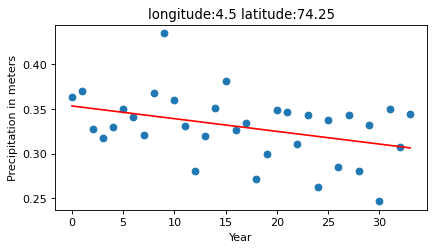

In [7]:
%matplotlib inline

plt.figure(figsize=(6, 3), dpi=80)
l=[]

longitude,latitude=4.7110,74.0721
# ilon, ilat = 120, 100
# longitude, latitude = lon[ilon], lat[ilat]
for i in np.arange(34):
    l+=[fll(i,longitude,latitude)]
x=np.arange(34)
y=l
res = stats.linregress(x,y)
print(f"R-squared: {res.rvalue**2:.6f}")
plt.plot(x, y, 'o', label='original data')
print(res.slope)
print(res.intercept)
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line') 
plt.xlabel("Year")
plt.ylabel("Precipitation in meters")
plt.title(f"longitude:{nearestlon(longitude)} latitude:{nearestlat(latitude)}")
plt.show()

In [ ]:
# BEFORE CONTINUING
# READ THIS
# THESE VALUES ARE EXACT AND FIT TO THE GRAPHS
# YOU DO NOT NEED TO CHANGE THEM IF YOU WANT SPECIFIC DATA
# IF YOU WANT TO CREATE PRETTY GRAPHS GO AHEAD
# --------------------
# YES IM TALKING TO YOU
# YES IM TALKING TO YOU
# YES IM TALKING TO YOU
# YES IM TALKING TO YOU
# YES IM TALKING TO YOU
# YES IM TALKING TO YOU
# YES IM TALKING TO YOU
# YES IM TALKING TO YOU
# YES IM TALKING TO YOU
# YES IM TALKING TO YOU
# YES IM TALKING TO YOU

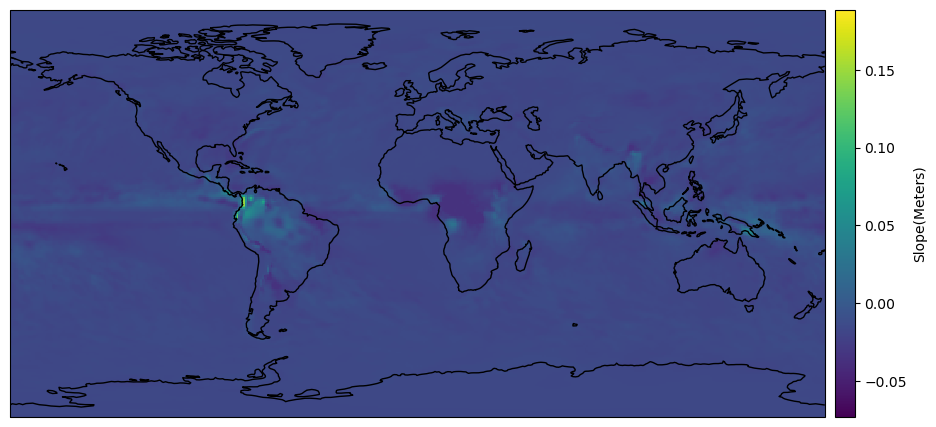

In [6]:
### Open the regression data file
ds = xr.open_dataset('regression.nc')

# maxes and mins
# auto adjusts vmin vmax but whatever
SLOPE_MEAN = 0.0003906767655790805

# Get the slope variable from the dataset
slope = ds['slope']

# Set up the projection for the map
proj = ccrs.PlateCarree()

# Create a figure and axis for the map
fig, ax = plt.subplots(subplot_kw={'projection': proj}, figsize=(10, 10))
fig.tight_layout()

# Set the extent of the map
ax.set_extent([-180, 180, -90, 90], crs=proj)
# Add the slope data to the map as a pcolormesh
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", sns.color_palette("viridis"))
# im = ax.pcolormesh(slope.lon, slope.lat, slope, transform=proj, cmap=cmap, vmin=-.015, vmax=0.2)
im = ax.pcolormesh(lon, lat, slope, transform=proj, cmap=cmap, norm = matplotlib.colors.SymLogNorm(linthresh=.1, vmin=-.015, vmax=0.2))
# Add a colorbar
cb = plt.colorbar(ax.imshow(slope), ax=ax, orientation="vertical", shrink=0.42, pad=0.01)
cb.set_label("Slope(Meters)")

# Add coastlines and a title
ax.coastlines()
# ax.set_title("Intercepts of Linear Regression of Total Precipitation(1984-2017)")

plt.show()


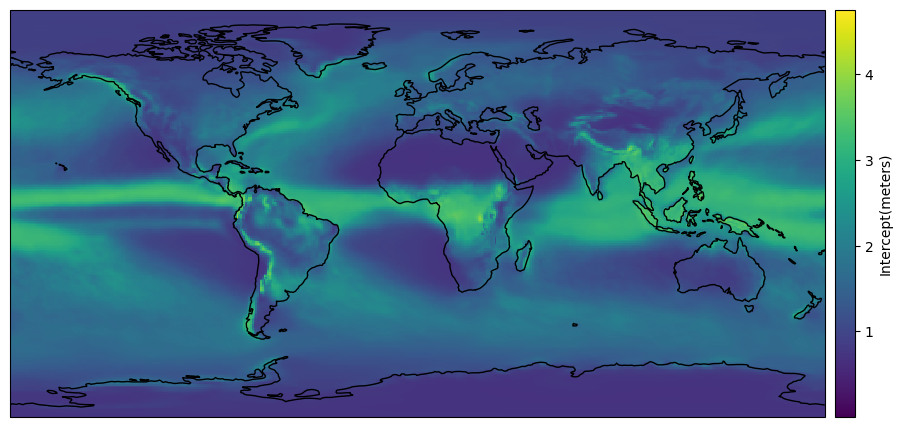

In [7]:
# Open the regression data file
ds = xr.open_dataset('regression.nc')

# maxes and mins
# auto adjusts vmin vmax but whatever
INTERCEPT_MEAN=2.118391669232234

# Get the slope variable from the dataset
intercept = ds['intercept']

# Set up the projection for the map
proj = ccrs.PlateCarree()

# Create a figure and axis for the map
fig, ax = plt.subplots(subplot_kw={'projection': proj}, figsize=(10, 10))
fig.tight_layout()
# Set the extent of the map
ax.set_extent([-180, 180, -90, 90], crs=proj)

# Add the slope data to the map as a pcolormesh
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", sns.color_palette("viridis"))
# im = ax.pcolormesh(lon, lat, intercept, transform=proj, cmap=cmap, vmin=0, vmax=5)
im = ax.pcolormesh(lon, lat, intercept, transform=proj, cmap=cmap, norm = matplotlib.colors.SymLogNorm(linthresh=1))

# Add a colorbar
cb = plt.colorbar(ax.imshow(intercept), ax=ax, orientation="vertical", shrink=0.42, pad=0.01)
cb.set_label("Intercept(meters)")

# Add coastlines and a title
ax.coastlines()
# ax.set_title("Slopes of Linear Regression of Total Precipitation(1984-2017)")

plt.show()


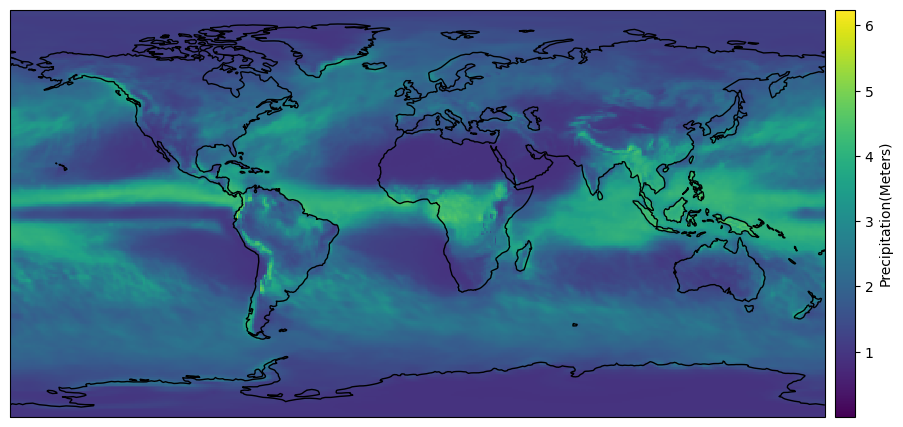

In [20]:
# this is default, for 1984-01-01
# default graph
MIN=-3.5762786865234375e-07
MAX=46.86285400390625
AVERAGE=2.1248369216918945
# Get the slope variable from the dataset
p0 = annual_sums[0]

# Set up the projection for the map
proj = ccrs.PlateCarree()

sns.set_style()
# Create a figure and axis for the map
fig, ax = plt.subplots(subplot_kw={'projection': proj}, figsize=(10, 10))
fig.tight_layout()
# Set the extent of the map
ax.set_extent([-180, 180, -90, 90], crs=proj)

# Add the slope data to the map as a pcolormesh
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", sns.color_palette("viridis"))
# im = ax.pcolormesh(lon, lat, p0, transform=proj, cmap=cmap, vmin=0, vmax=6)
im = ax.pcolormesh(lon, lat, p0, transform=proj, cmap=cmap, norm =matplotlib.colors.SymLogNorm(linthresh=1))

# Add a colorbar
# fig.colorbar(ax.imshow(p0))
# cb = plt.colorbar(im, ax=ax, orientation="vertical", shrink=0.42, pad=0.01)
cb = plt.colorbar(ax.imshow(p0), ax=ax, orientation="vertical", shrink=0.42, pad=0.01)
cb.set_label("Precipitation(Meters)")

# Add coastlines and a title
ax.coastlines()

plt.show()

In [39]:
# default map saver
MIN=-3.5762786865234375e-07
MAX=46.86285400390625
AVERAGE=2.1248369216918945

for year in tqdm(range(34)):
    # Get the slope variable from the dataset
    p = annual_sums[year]

    # Set up the projection for the map
    proj = ccrs.PlateCarree()

    sns.set_style()
    # Create a figure and axis for the map
    fig, ax = plt.subplots(subplot_kw={'projection': proj}, figsize=(10, 10))
    fig.tight_layout()
    # Set the extent of the map
    ax.set_extent([-180, 180, -90, 90], crs=proj)

    # Add the slope data to the map as a pcolormesh
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", sns.color_palette("viridis"))
    # im = ax.pcolormesh(lon, lat, p0, transform=proj, cmap=cmap, vmin=0, vmax=6)
    im = ax.pcolormesh(lon, lat, p, transform=proj, cmap=cmap, norm = matplotlib.colors.SymLogNorm(linthresh=1))

    # Add a colorbar
    # fig.colorbar(ax.imshow(p0))
    # cb = plt.colorbar(im, ax=ax, orientation="vertical", shrink=0.42, pad=0.01)
    cb = plt.colorbar(ax.imshow(p0), ax=ax, orientation="vertical", shrink=0.42, pad=0.01)
    cb.set_label("Precipitation(Meters)")

    # Add coastlines and a title
    ax.coastlines()
    ax.set_title(f"{year+1984}")
    plt.savefig(f"../fig/{year+1984}.png",bbox_inches='tight',dpi=500)
    matplotlib.pyplot.close()

100%|███████████████████████████████████████████| 34/34 [00:36<00:00,  1.07s/it]


In [34]:
os.getcwd()

'/Users/coder/codez/py/anaconda-environmentors/data'